In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['roi']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_0_t1t2_normalized_e_n_e_1_1_e_1_0_diffusion_fa_data_norm_b25_roi_t1_native_k5_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(463113, 304)
(463113, 1)
validation
(87055, 304)
(87055, 1)
test
(43409, 304)
(43409, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 304)]             0         


 dense (Dense)               (None, 1024)              312320    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1001473 (3.82 MB)


Trainable params: 1001473 (3.82 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/47 [..............................] - ETA: 1:00 - loss: 0.0324 - STD: 6.1399e-05 - MAE: 0.1618

 5/47 [==>...........................] - ETA: 0s - loss: 0.0223 - STD: 5.6463e-05 - MAE: 0.1148  

 9/47 [====>.........................] - ETA: 0s - loss: 0.0200 - STD: 6.1682e-05 - MAE: 0.1060

13/47 [=======>......................] - ETA: 0s - loss: 0.0182 - STD: 8.0058e-05 - MAE: 0.1037

17/47 [=========>....................] - ETA: 0s - loss: 0.0170 - STD: 9.7148e-05 - MAE: 0.1012

21/47 [============>.................] - ETA: 0s - loss: 0.0162 - STD: 1.0874e-04 - MAE: 0.0979

25/47 [==============>...............] - ETA: 0s - loss: 0.0157 - STD: 1.2147e-04 - MAE: 0.0955

27/47 [================>.............] - ETA: 0s - loss: 0.0155 - STD: 1.2943e-04 - MAE: 0.0948

31/47 [==================>...........] - ETA: 0s - loss: 0.0151 - STD: 1.4681e-04 - MAE: 0.0942

35/47 [=====================>........] - ETA: 0s - loss: 0.0147 - STD: 1.6289e-04 - MAE: 0.0933

39/47 [=======================>......] - ETA: 0s - loss: 0.0145 - STD: 1.7768e-04 - MAE: 0.0923

43/47 [==========================>...] - ETA: 0s - loss: 0.0142 - STD: 1.9385e-04 - MAE: 0.0916

47/47 [==============================] - ETA: 0s - loss: 0.0141 - STD: 2.1254e-04 - MAE: 0.0912

47/47 [==============================] - 3s 42ms/step - loss: 0.0141 - STD: 2.1254e-04 - MAE: 0.0912 - val_loss: 0.0138 - val_STD: 4.3590e-04 - val_MAE: 0.0933


Epoch 2/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0120 - STD: 4.4450e-04 - MAE: 0.0873

 5/47 [==>...........................] - ETA: 0s - loss: 0.0120 - STD: 4.6179e-04 - MAE: 0.0857

 9/47 [====>.........................] - ETA: 0s - loss: 0.0120 - STD: 4.8452e-04 - MAE: 0.0849

14/47 [=======>......................] - ETA: 0s - loss: 0.0120 - STD: 5.2540e-04 - MAE: 0.0849

18/47 [==========>...................] - ETA: 0s - loss: 0.0120 - STD: 5.6324e-04 - MAE: 0.0852

22/47 [=============>................] - ETA: 0s - loss: 0.0120 - STD: 6.0157e-04 - MAE: 0.0850

26/47 [===============>..............] - ETA: 0s - loss: 0.0120 - STD: 6.4348e-04 - MAE: 0.0849

30/47 [==================>...........] - ETA: 0s - loss: 0.0120 - STD: 6.9383e-04 - MAE: 0.0851

34/47 [====================>.........] - ETA: 0s - loss: 0.0119 - STD: 7.4834e-04 - MAE: 0.0850

38/47 [=======================>......] - ETA: 0s - loss: 0.0120 - STD: 8.1015e-04 - MAE: 0.0850

42/47 [=========================>....] - ETA: 0s - loss: 0.0120 - STD: 8.8156e-04 - MAE: 0.0850

46/47 [============================>.] - ETA: 0s - loss: 0.0119 - STD: 9.6609e-04 - MAE: 0.0850

47/47 [==============================] - 1s 16ms/step - loss: 0.0119 - STD: 9.8889e-04 - MAE: 0.0850 - val_loss: 0.0138 - val_STD: 0.0021 - val_MAE: 0.0916


Epoch 3/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0114 - STD: 0.0021 - MAE: 0.0834

 5/47 [==>...........................] - ETA: 0s - loss: 0.0117 - STD: 0.0023 - MAE: 0.0837

 9/47 [====>.........................] - ETA: 0s - loss: 0.0118 - STD: 0.0026 - MAE: 0.0843

13/47 [=======>......................] - ETA: 0s - loss: 0.0117 - STD: 0.0029 - MAE: 0.0843

17/47 [=========>....................] - ETA: 0s - loss: 0.0117 - STD: 0.0032 - MAE: 0.0843

21/47 [============>.................] - ETA: 0s - loss: 0.0117 - STD: 0.0036 - MAE: 0.0842

25/47 [==============>...............] - ETA: 0s - loss: 0.0116 - STD: 0.0042 - MAE: 0.0841

29/47 [=================>............] - ETA: 0s - loss: 0.0116 - STD: 0.0048 - MAE: 0.0839

34/47 [====================>.........] - ETA: 0s - loss: 0.0115 - STD: 0.0059 - MAE: 0.0835

38/47 [=======================>......] - ETA: 0s - loss: 0.0114 - STD: 0.0071 - MAE: 0.0832

42/47 [=========================>....] - ETA: 0s - loss: 0.0113 - STD: 0.0086 - MAE: 0.0830

46/47 [============================>.] - ETA: 0s - loss: 0.0112 - STD: 0.0104 - MAE: 0.0826

47/47 [==============================] - 1s 17ms/step - loss: 0.0111 - STD: 0.0109 - MAE: 0.0825 - val_loss: 0.0116 - val_STD: 0.0350 - val_MAE: 0.0851


Epoch 4/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0096 - STD: 0.0358 - MAE: 0.0764

 5/47 [==>...........................] - ETA: 0s - loss: 0.0096 - STD: 0.0392 - MAE: 0.0769

 9/47 [====>.........................] - ETA: 0s - loss: 0.0095 - STD: 0.0424 - MAE: 0.0765

13/47 [=======>......................] - ETA: 0s - loss: 0.0096 - STD: 0.0449 - MAE: 0.0765

17/47 [=========>....................] - ETA: 0s - loss: 0.0095 - STD: 0.0465 - MAE: 0.0762

21/47 [============>.................] - ETA: 0s - loss: 0.0095 - STD: 0.0476 - MAE: 0.0759

25/47 [==============>...............] - ETA: 0s - loss: 0.0094 - STD: 0.0482 - MAE: 0.0757

29/47 [=================>............] - ETA: 0s - loss: 0.0094 - STD: 0.0485 - MAE: 0.0755

34/47 [====================>.........] - ETA: 0s - loss: 0.0093 - STD: 0.0488 - MAE: 0.0752

38/47 [=======================>......] - ETA: 0s - loss: 0.0093 - STD: 0.0491 - MAE: 0.0751

42/47 [=========================>....] - ETA: 0s - loss: 0.0093 - STD: 0.0493 - MAE: 0.0748

46/47 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 0.0496 - MAE: 0.0746

47/47 [==============================] - 1s 16ms/step - loss: 0.0092 - STD: 0.0497 - MAE: 0.0746 - val_loss: 0.0106 - val_STD: 0.0510 - val_MAE: 0.0800


Epoch 5/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0088 - STD: 0.0519 - MAE: 0.0719

 5/47 [==>...........................] - ETA: 0s - loss: 0.0086 - STD: 0.0526 - MAE: 0.0715

 9/47 [====>.........................] - ETA: 0s - loss: 0.0086 - STD: 0.0530 - MAE: 0.0714

14/47 [=======>......................] - ETA: 0s - loss: 0.0085 - STD: 0.0535 - MAE: 0.0712

18/47 [==========>...................] - ETA: 0s - loss: 0.0085 - STD: 0.0539 - MAE: 0.0710

22/47 [=============>................] - ETA: 0s - loss: 0.0084 - STD: 0.0543 - MAE: 0.0707

26/47 [===============>..............] - ETA: 0s - loss: 0.0084 - STD: 0.0548 - MAE: 0.0705

30/47 [==================>...........] - ETA: 0s - loss: 0.0083 - STD: 0.0554 - MAE: 0.0702

34/47 [====================>.........] - ETA: 0s - loss: 0.0083 - STD: 0.0560 - MAE: 0.0701

38/47 [=======================>......] - ETA: 0s - loss: 0.0083 - STD: 0.0564 - MAE: 0.0698

42/47 [=========================>....] - ETA: 0s - loss: 0.0082 - STD: 0.0570 - MAE: 0.0696

46/47 [============================>.] - ETA: 0s - loss: 0.0082 - STD: 0.0573 - MAE: 0.0694

47/47 [==============================] - 1s 17ms/step - loss: 0.0082 - STD: 0.0575 - MAE: 0.0694 - val_loss: 0.0094 - val_STD: 0.0633 - val_MAE: 0.0751


Epoch 6/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0077 - STD: 0.0634 - MAE: 0.0676

 5/47 [==>...........................] - ETA: 0s - loss: 0.0077 - STD: 0.0626 - MAE: 0.0666

 9/47 [====>.........................] - ETA: 0s - loss: 0.0076 - STD: 0.0629 - MAE: 0.0661

13/47 [=======>......................] - ETA: 0s - loss: 0.0075 - STD: 0.0630 - MAE: 0.0659

17/47 [=========>....................] - ETA: 0s - loss: 0.0075 - STD: 0.0634 - MAE: 0.0659

21/47 [============>.................] - ETA: 0s - loss: 0.0075 - STD: 0.0635 - MAE: 0.0657

25/47 [==============>...............] - ETA: 0s - loss: 0.0075 - STD: 0.0638 - MAE: 0.0655

29/47 [=================>............] - ETA: 0s - loss: 0.0074 - STD: 0.0642 - MAE: 0.0654

33/47 [====================>.........] - ETA: 0s - loss: 0.0074 - STD: 0.0644 - MAE: 0.0654

37/47 [======================>.......] - ETA: 0s - loss: 0.0074 - STD: 0.0644 - MAE: 0.0652

41/47 [=========================>....] - ETA: 0s - loss: 0.0074 - STD: 0.0648 - MAE: 0.0651

45/47 [===========================>..] - ETA: 0s - loss: 0.0074 - STD: 0.0649 - MAE: 0.0650

47/47 [==============================] - 1s 17ms/step - loss: 0.0074 - STD: 0.0649 - MAE: 0.0649 - val_loss: 0.0089 - val_STD: 0.0708 - val_MAE: 0.0729


Epoch 7/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0070 - STD: 0.0699 - MAE: 0.0643

 5/47 [==>...........................] - ETA: 0s - loss: 0.0071 - STD: 0.0683 - MAE: 0.0639

 9/47 [====>.........................] - ETA: 0s - loss: 0.0072 - STD: 0.0681 - MAE: 0.0639

13/47 [=======>......................] - ETA: 0s - loss: 0.0073 - STD: 0.0686 - MAE: 0.0645

17/47 [=========>....................] - ETA: 0s - loss: 0.0075 - STD: 0.0677 - MAE: 0.0649

22/47 [=============>................] - ETA: 0s - loss: 0.0075 - STD: 0.0668 - MAE: 0.0649

26/47 [===============>..............] - ETA: 0s - loss: 0.0075 - STD: 0.0665 - MAE: 0.0650

30/47 [==================>...........] - ETA: 0s - loss: 0.0075 - STD: 0.0660 - MAE: 0.0650

34/47 [====================>.........] - ETA: 0s - loss: 0.0075 - STD: 0.0658 - MAE: 0.0650

38/47 [=======================>......] - ETA: 0s - loss: 0.0075 - STD: 0.0656 - MAE: 0.0649

42/47 [=========================>....] - ETA: 0s - loss: 0.0074 - STD: 0.0657 - MAE: 0.0648

46/47 [============================>.] - ETA: 0s - loss: 0.0074 - STD: 0.0658 - MAE: 0.0646

47/47 [==============================] - 1s 17ms/step - loss: 0.0074 - STD: 0.0658 - MAE: 0.0646 - val_loss: 0.0088 - val_STD: 0.0703 - val_MAE: 0.0719


Epoch 8/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0068 - STD: 0.0691 - MAE: 0.0629

 5/47 [==>...........................] - ETA: 0s - loss: 0.0070 - STD: 0.0687 - MAE: 0.0628

 9/47 [====>.........................] - ETA: 0s - loss: 0.0069 - STD: 0.0690 - MAE: 0.0626

13/47 [=======>......................] - ETA: 0s - loss: 0.0069 - STD: 0.0694 - MAE: 0.0625

17/47 [=========>....................] - ETA: 0s - loss: 0.0069 - STD: 0.0695 - MAE: 0.0624

21/47 [============>.................] - ETA: 0s - loss: 0.0069 - STD: 0.0697 - MAE: 0.0624

25/47 [==============>...............] - ETA: 0s - loss: 0.0069 - STD: 0.0698 - MAE: 0.0623

29/47 [=================>............] - ETA: 0s - loss: 0.0069 - STD: 0.0699 - MAE: 0.0623

34/47 [====================>.........] - ETA: 0s - loss: 0.0069 - STD: 0.0701 - MAE: 0.0623

38/47 [=======================>......] - ETA: 0s - loss: 0.0069 - STD: 0.0701 - MAE: 0.0623

42/47 [=========================>....] - ETA: 0s - loss: 0.0069 - STD: 0.0701 - MAE: 0.0623

46/47 [============================>.] - ETA: 0s - loss: 0.0069 - STD: 0.0702 - MAE: 0.0623

47/47 [==============================] - 1s 16ms/step - loss: 0.0069 - STD: 0.0704 - MAE: 0.0624 - val_loss: 0.0088 - val_STD: 0.0724 - val_MAE: 0.0708


Epoch 9/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0067 - STD: 0.0708 - MAE: 0.0612

 5/47 [==>...........................] - ETA: 0s - loss: 0.0068 - STD: 0.0704 - MAE: 0.0615

 9/47 [====>.........................] - ETA: 0s - loss: 0.0068 - STD: 0.0706 - MAE: 0.0616

13/47 [=======>......................] - ETA: 0s - loss: 0.0068 - STD: 0.0708 - MAE: 0.0618

17/47 [=========>....................] - ETA: 0s - loss: 0.0068 - STD: 0.0709 - MAE: 0.0618

21/47 [============>.................] - ETA: 0s - loss: 0.0068 - STD: 0.0708 - MAE: 0.0619

25/47 [==============>...............] - ETA: 0s - loss: 0.0068 - STD: 0.0707 - MAE: 0.0618

29/47 [=================>............] - ETA: 0s - loss: 0.0068 - STD: 0.0707 - MAE: 0.0619

33/47 [====================>.........] - ETA: 0s - loss: 0.0068 - STD: 0.0708 - MAE: 0.0620

37/47 [======================>.......] - ETA: 0s - loss: 0.0068 - STD: 0.0709 - MAE: 0.0620

42/47 [=========================>....] - ETA: 0s - loss: 0.0068 - STD: 0.0708 - MAE: 0.0619

46/47 [============================>.] - ETA: 0s - loss: 0.0068 - STD: 0.0709 - MAE: 0.0619

47/47 [==============================] - 1s 16ms/step - loss: 0.0068 - STD: 0.0710 - MAE: 0.0620 - val_loss: 0.0087 - val_STD: 0.0718 - val_MAE: 0.0703


Epoch 10/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0066 - STD: 0.0700 - MAE: 0.0603

 5/47 [==>...........................] - ETA: 0s - loss: 0.0068 - STD: 0.0705 - MAE: 0.0615

 9/47 [====>.........................] - ETA: 0s - loss: 0.0068 - STD: 0.0713 - MAE: 0.0618

14/47 [=======>......................] - ETA: 0s - loss: 0.0069 - STD: 0.0714 - MAE: 0.0621

18/47 [==========>...................] - ETA: 0s - loss: 0.0068 - STD: 0.0711 - MAE: 0.0620

22/47 [=============>................] - ETA: 0s - loss: 0.0068 - STD: 0.0712 - MAE: 0.0619

26/47 [===============>..............] - ETA: 0s - loss: 0.0068 - STD: 0.0713 - MAE: 0.0619

30/47 [==================>...........] - ETA: 0s - loss: 0.0068 - STD: 0.0712 - MAE: 0.0617

34/47 [====================>.........] - ETA: 0s - loss: 0.0068 - STD: 0.0712 - MAE: 0.0617

38/47 [=======================>......] - ETA: 0s - loss: 0.0068 - STD: 0.0713 - MAE: 0.0616

42/47 [=========================>....] - ETA: 0s - loss: 0.0068 - STD: 0.0714 - MAE: 0.0617

46/47 [============================>.] - ETA: 0s - loss: 0.0068 - STD: 0.0714 - MAE: 0.0617

47/47 [==============================] - 1s 16ms/step - loss: 0.0068 - STD: 0.0714 - MAE: 0.0616 - val_loss: 0.0088 - val_STD: 0.0746 - val_MAE: 0.0712


Epoch 11/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0068 - STD: 0.0723 - MAE: 0.0619

 5/47 [==>...........................] - ETA: 0s - loss: 0.0067 - STD: 0.0726 - MAE: 0.0616

 9/47 [====>.........................] - ETA: 0s - loss: 0.0068 - STD: 0.0725 - MAE: 0.0616

13/47 [=======>......................] - ETA: 0s - loss: 0.0067 - STD: 0.0726 - MAE: 0.0616

18/47 [==========>...................] - ETA: 0s - loss: 0.0067 - STD: 0.0727 - MAE: 0.0615

22/47 [=============>................] - ETA: 0s - loss: 0.0067 - STD: 0.0726 - MAE: 0.0613

26/47 [===============>..............] - ETA: 0s - loss: 0.0067 - STD: 0.0726 - MAE: 0.0612

30/47 [==================>...........] - ETA: 0s - loss: 0.0067 - STD: 0.0725 - MAE: 0.0612

34/47 [====================>.........] - ETA: 0s - loss: 0.0067 - STD: 0.0726 - MAE: 0.0612

38/47 [=======================>......] - ETA: 0s - loss: 0.0067 - STD: 0.0724 - MAE: 0.0612

42/47 [=========================>....] - ETA: 0s - loss: 0.0067 - STD: 0.0724 - MAE: 0.0612

46/47 [============================>.] - ETA: 0s - loss: 0.0067 - STD: 0.0725 - MAE: 0.0613

47/47 [==============================] - 1s 16ms/step - loss: 0.0067 - STD: 0.0724 - MAE: 0.0613 - val_loss: 0.0088 - val_STD: 0.0756 - val_MAE: 0.0716


Epoch 12/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0065 - STD: 0.0738 - MAE: 0.0607

 5/47 [==>...........................] - ETA: 0s - loss: 0.0067 - STD: 0.0727 - MAE: 0.0613

 9/47 [====>.........................] - ETA: 0s - loss: 0.0067 - STD: 0.0725 - MAE: 0.0611

13/47 [=======>......................] - ETA: 0s - loss: 0.0067 - STD: 0.0725 - MAE: 0.0611

17/47 [=========>....................] - ETA: 0s - loss: 0.0068 - STD: 0.0727 - MAE: 0.0615

22/47 [=============>................] - ETA: 0s - loss: 0.0068 - STD: 0.0723 - MAE: 0.0617

26/47 [===============>..............] - ETA: 0s - loss: 0.0069 - STD: 0.0719 - MAE: 0.0618

30/47 [==================>...........] - ETA: 0s - loss: 0.0071 - STD: 0.0717 - MAE: 0.0628

34/47 [====================>.........] - ETA: 0s - loss: 0.0071 - STD: 0.0711 - MAE: 0.0630

38/47 [=======================>......] - ETA: 0s - loss: 0.0071 - STD: 0.0704 - MAE: 0.0630

42/47 [=========================>....] - ETA: 0s - loss: 0.0071 - STD: 0.0698 - MAE: 0.0629

46/47 [============================>.] - ETA: 0s - loss: 0.0070 - STD: 0.0695 - MAE: 0.0629

47/47 [==============================] - 1s 17ms/step - loss: 0.0070 - STD: 0.0694 - MAE: 0.0628 - val_loss: 0.0086 - val_STD: 0.0672 - val_MAE: 0.0696


Epoch 13/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0070 - STD: 0.0651 - MAE: 0.0619

 5/47 [==>...........................] - ETA: 0s - loss: 0.0069 - STD: 0.0684 - MAE: 0.0624

 9/47 [====>.........................] - ETA: 0s - loss: 0.0068 - STD: 0.0697 - MAE: 0.0620

13/47 [=======>......................] - ETA: 0s - loss: 0.0068 - STD: 0.0706 - MAE: 0.0619

18/47 [==========>...................] - ETA: 0s - loss: 0.0068 - STD: 0.0710 - MAE: 0.0617

22/47 [=============>................] - ETA: 0s - loss: 0.0068 - STD: 0.0712 - MAE: 0.0616

26/47 [===============>..............] - ETA: 0s - loss: 0.0067 - STD: 0.0713 - MAE: 0.0614

30/47 [==================>...........] - ETA: 0s - loss: 0.0067 - STD: 0.0714 - MAE: 0.0613

34/47 [====================>.........] - ETA: 0s - loss: 0.0067 - STD: 0.0715 - MAE: 0.0612

38/47 [=======================>......] - ETA: 0s - loss: 0.0067 - STD: 0.0717 - MAE: 0.0612

42/47 [=========================>....] - ETA: 0s - loss: 0.0067 - STD: 0.0718 - MAE: 0.0612

46/47 [============================>.] - ETA: 0s - loss: 0.0067 - STD: 0.0719 - MAE: 0.0611

47/47 [==============================] - 1s 16ms/step - loss: 0.0067 - STD: 0.0719 - MAE: 0.0611 - val_loss: 0.0088 - val_STD: 0.0767 - val_MAE: 0.0715


Epoch 14/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0066 - STD: 0.0750 - MAE: 0.0611

 6/47 [==>...........................] - ETA: 0s - loss: 0.0066 - STD: 0.0736 - MAE: 0.0609

10/47 [=====>........................] - ETA: 0s - loss: 0.0066 - STD: 0.0731 - MAE: 0.0609

14/47 [=======>......................] - ETA: 0s - loss: 0.0066 - STD: 0.0730 - MAE: 0.0608

18/47 [==========>...................] - ETA: 0s - loss: 0.0066 - STD: 0.0729 - MAE: 0.0608

22/47 [=============>................] - ETA: 0s - loss: 0.0066 - STD: 0.0728 - MAE: 0.0607

26/47 [===============>..............] - ETA: 0s - loss: 0.0066 - STD: 0.0728 - MAE: 0.0607

30/47 [==================>...........] - ETA: 0s - loss: 0.0066 - STD: 0.0728 - MAE: 0.0607

34/47 [====================>.........] - ETA: 0s - loss: 0.0066 - STD: 0.0729 - MAE: 0.0607

38/47 [=======================>......] - ETA: 0s - loss: 0.0066 - STD: 0.0731 - MAE: 0.0607

42/47 [=========================>....] - ETA: 0s - loss: 0.0066 - STD: 0.0731 - MAE: 0.0607

46/47 [============================>.] - ETA: 0s - loss: 0.0066 - STD: 0.0731 - MAE: 0.0607

47/47 [==============================] - 1s 16ms/step - loss: 0.0066 - STD: 0.0731 - MAE: 0.0607 - val_loss: 0.0087 - val_STD: 0.0757 - val_MAE: 0.0708


Epoch 15/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0065 - STD: 0.0733 - MAE: 0.0597

 5/47 [==>...........................] - ETA: 0s - loss: 0.0064 - STD: 0.0732 - MAE: 0.0601

 9/47 [====>.........................] - ETA: 0s - loss: 0.0065 - STD: 0.0732 - MAE: 0.0603

13/47 [=======>......................] - ETA: 0s - loss: 0.0066 - STD: 0.0732 - MAE: 0.0605

17/47 [=========>....................] - ETA: 0s - loss: 0.0065 - STD: 0.0733 - MAE: 0.0605

21/47 [============>.................] - ETA: 0s - loss: 0.0066 - STD: 0.0732 - MAE: 0.0605

25/47 [==============>...............] - ETA: 0s - loss: 0.0066 - STD: 0.0732 - MAE: 0.0605

30/47 [==================>...........] - ETA: 0s - loss: 0.0066 - STD: 0.0733 - MAE: 0.0605

34/47 [====================>.........] - ETA: 0s - loss: 0.0066 - STD: 0.0733 - MAE: 0.0605

38/47 [=======================>......] - ETA: 0s - loss: 0.0066 - STD: 0.0735 - MAE: 0.0605

42/47 [=========================>....] - ETA: 0s - loss: 0.0066 - STD: 0.0735 - MAE: 0.0605

46/47 [============================>.] - ETA: 0s - loss: 0.0066 - STD: 0.0735 - MAE: 0.0605

47/47 [==============================] - 1s 16ms/step - loss: 0.0066 - STD: 0.0735 - MAE: 0.0605 - val_loss: 0.0087 - val_STD: 0.0762 - val_MAE: 0.0710


Epoch 16/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0063 - STD: 0.0748 - MAE: 0.0596

 5/47 [==>...........................] - ETA: 0s - loss: 0.0065 - STD: 0.0734 - MAE: 0.0605

 9/47 [====>.........................] - ETA: 0s - loss: 0.0066 - STD: 0.0733 - MAE: 0.0605

13/47 [=======>......................] - ETA: 0s - loss: 0.0066 - STD: 0.0733 - MAE: 0.0604

17/47 [=========>....................] - ETA: 0s - loss: 0.0065 - STD: 0.0733 - MAE: 0.0603

21/47 [============>.................] - ETA: 0s - loss: 0.0066 - STD: 0.0734 - MAE: 0.0604

25/47 [==============>...............] - ETA: 0s - loss: 0.0066 - STD: 0.0735 - MAE: 0.0604

29/47 [=================>............] - ETA: 0s - loss: 0.0066 - STD: 0.0735 - MAE: 0.0604

33/47 [====================>.........] - ETA: 0s - loss: 0.0065 - STD: 0.0735 - MAE: 0.0603

37/47 [======================>.......] - ETA: 0s - loss: 0.0065 - STD: 0.0735 - MAE: 0.0603

41/47 [=========================>....] - ETA: 0s - loss: 0.0065 - STD: 0.0734 - MAE: 0.0603

45/47 [===========================>..] - ETA: 0s - loss: 0.0065 - STD: 0.0734 - MAE: 0.0603

47/47 [==============================] - 1s 16ms/step - loss: 0.0065 - STD: 0.0734 - MAE: 0.0603 - val_loss: 0.0088 - val_STD: 0.0780 - val_MAE: 0.0714


Epoch 17/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0064 - STD: 0.0759 - MAE: 0.0602

 5/47 [==>...........................] - ETA: 0s - loss: 0.0065 - STD: 0.0747 - MAE: 0.0603

 9/47 [====>.........................] - ETA: 0s - loss: 0.0065 - STD: 0.0741 - MAE: 0.0604

13/47 [=======>......................] - ETA: 0s - loss: 0.0066 - STD: 0.0741 - MAE: 0.0605

17/47 [=========>....................] - ETA: 0s - loss: 0.0066 - STD: 0.0739 - MAE: 0.0604

21/47 [============>.................] - ETA: 0s - loss: 0.0065 - STD: 0.0739 - MAE: 0.0603

25/47 [==============>...............] - ETA: 0s - loss: 0.0065 - STD: 0.0739 - MAE: 0.0603

29/47 [=================>............] - ETA: 0s - loss: 0.0065 - STD: 0.0739 - MAE: 0.0603

33/47 [====================>.........] - ETA: 0s - loss: 0.0065 - STD: 0.0737 - MAE: 0.0602

37/47 [======================>.......] - ETA: 0s - loss: 0.0065 - STD: 0.0738 - MAE: 0.0603

41/47 [=========================>....] - ETA: 0s - loss: 0.0065 - STD: 0.0736 - MAE: 0.0602

46/47 [============================>.] - ETA: 0s - loss: 0.0065 - STD: 0.0737 - MAE: 0.0602

47/47 [==============================] - 1s 16ms/step - loss: 0.0065 - STD: 0.0736 - MAE: 0.0602 - val_loss: 0.0090 - val_STD: 0.0802 - val_MAE: 0.0731


Epoch 18/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0067 - STD: 0.0783 - MAE: 0.0625

 5/47 [==>...........................] - ETA: 0s - loss: 0.0066 - STD: 0.0736 - MAE: 0.0607

10/47 [=====>........................] - ETA: 0s - loss: 0.0066 - STD: 0.0741 - MAE: 0.0604

14/47 [=======>......................] - ETA: 0s - loss: 0.0066 - STD: 0.0736 - MAE: 0.0605

18/47 [==========>...................] - ETA: 0s - loss: 0.0066 - STD: 0.0737 - MAE: 0.0604

22/47 [=============>................] - ETA: 0s - loss: 0.0066 - STD: 0.0736 - MAE: 0.0604

26/47 [===============>..............] - ETA: 0s - loss: 0.0066 - STD: 0.0732 - MAE: 0.0606

30/47 [==================>...........] - ETA: 0s - loss: 0.0066 - STD: 0.0732 - MAE: 0.0605

34/47 [====================>.........] - ETA: 0s - loss: 0.0066 - STD: 0.0733 - MAE: 0.0606

38/47 [=======================>......] - ETA: 0s - loss: 0.0066 - STD: 0.0732 - MAE: 0.0605

42/47 [=========================>....] - ETA: 0s - loss: 0.0066 - STD: 0.0732 - MAE: 0.0605

46/47 [============================>.] - ETA: 0s - loss: 0.0066 - STD: 0.0732 - MAE: 0.0607

47/47 [==============================] - 1s 16ms/step - loss: 0.0066 - STD: 0.0730 - MAE: 0.0607 - val_loss: 0.0084 - val_STD: 0.0715 - val_MAE: 0.0690


Epoch 19/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0065 - STD: 0.0690 - MAE: 0.0597

 5/47 [==>...........................] - ETA: 0s - loss: 0.0072 - STD: 0.0715 - MAE: 0.0635

10/47 [=====>........................] - ETA: 0s - loss: 0.0071 - STD: 0.0687 - MAE: 0.0627

14/47 [=======>......................] - ETA: 0s - loss: 0.0069 - STD: 0.0688 - MAE: 0.0622

18/47 [==========>...................] - ETA: 0s - loss: 0.0068 - STD: 0.0694 - MAE: 0.0618

22/47 [=============>................] - ETA: 0s - loss: 0.0068 - STD: 0.0701 - MAE: 0.0615

26/47 [===============>..............] - ETA: 0s - loss: 0.0067 - STD: 0.0707 - MAE: 0.0612

30/47 [==================>...........] - ETA: 0s - loss: 0.0067 - STD: 0.0712 - MAE: 0.0611

34/47 [====================>.........] - ETA: 0s - loss: 0.0066 - STD: 0.0715 - MAE: 0.0608

38/47 [=======================>......] - ETA: 0s - loss: 0.0066 - STD: 0.0718 - MAE: 0.0607

42/47 [=========================>....] - ETA: 0s - loss: 0.0066 - STD: 0.0720 - MAE: 0.0607

46/47 [============================>.] - ETA: 0s - loss: 0.0066 - STD: 0.0722 - MAE: 0.0606

47/47 [==============================] - 1s 16ms/step - loss: 0.0066 - STD: 0.0722 - MAE: 0.0606 - val_loss: 0.0085 - val_STD: 0.0761 - val_MAE: 0.0700


Epoch 20/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0065 - STD: 0.0748 - MAE: 0.0607

 5/47 [==>...........................] - ETA: 0s - loss: 0.0063 - STD: 0.0740 - MAE: 0.0594

 9/47 [====>.........................] - ETA: 0s - loss: 0.0064 - STD: 0.0737 - MAE: 0.0596

13/47 [=======>......................] - ETA: 0s - loss: 0.0064 - STD: 0.0738 - MAE: 0.0596

17/47 [=========>....................] - ETA: 0s - loss: 0.0064 - STD: 0.0739 - MAE: 0.0597

21/47 [============>.................] - ETA: 0s - loss: 0.0064 - STD: 0.0742 - MAE: 0.0597

25/47 [==============>...............] - ETA: 0s - loss: 0.0064 - STD: 0.0742 - MAE: 0.0597

29/47 [=================>............] - ETA: 0s - loss: 0.0064 - STD: 0.0742 - MAE: 0.0596

33/47 [====================>.........] - ETA: 0s - loss: 0.0064 - STD: 0.0742 - MAE: 0.0596

37/47 [======================>.......] - ETA: 0s - loss: 0.0064 - STD: 0.0742 - MAE: 0.0596

42/47 [=========================>....] - ETA: 0s - loss: 0.0064 - STD: 0.0741 - MAE: 0.0596

46/47 [============================>.] - ETA: 0s - loss: 0.0064 - STD: 0.0742 - MAE: 0.0597

47/47 [==============================] - 1s 16ms/step - loss: 0.0064 - STD: 0.0743 - MAE: 0.0598 - val_loss: 0.0089 - val_STD: 0.0684 - val_MAE: 0.0690


Epoch 21/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0069 - STD: 0.0660 - MAE: 0.0602

 5/47 [==>...........................] - ETA: 0s - loss: 0.0067 - STD: 0.0711 - MAE: 0.0607

 9/47 [====>.........................] - ETA: 0s - loss: 0.0069 - STD: 0.0721 - MAE: 0.0621

13/47 [=======>......................] - ETA: 0s - loss: 0.0068 - STD: 0.0712 - MAE: 0.0615

17/47 [=========>....................] - ETA: 0s - loss: 0.0068 - STD: 0.0707 - MAE: 0.0612

21/47 [============>.................] - ETA: 0s - loss: 0.0067 - STD: 0.0707 - MAE: 0.0611

25/47 [==============>...............] - ETA: 0s - loss: 0.0067 - STD: 0.0712 - MAE: 0.0609

29/47 [=================>............] - ETA: 0s - loss: 0.0066 - STD: 0.0719 - MAE: 0.0607

33/47 [====================>.........] - ETA: 0s - loss: 0.0066 - STD: 0.0722 - MAE: 0.0606

37/47 [======================>.......] - ETA: 0s - loss: 0.0066 - STD: 0.0724 - MAE: 0.0605

42/47 [=========================>....] - ETA: 0s - loss: 0.0066 - STD: 0.0727 - MAE: 0.0605

46/47 [============================>.] - ETA: 0s - loss: 0.0066 - STD: 0.0726 - MAE: 0.0604

47/47 [==============================] - 1s 16ms/step - loss: 0.0066 - STD: 0.0725 - MAE: 0.0604 - val_loss: 0.0089 - val_STD: 0.0794 - val_MAE: 0.0725


Epoch 22/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0064 - STD: 0.0772 - MAE: 0.0611

 5/47 [==>...........................] - ETA: 0s - loss: 0.0064 - STD: 0.0739 - MAE: 0.0600

 9/47 [====>.........................] - ETA: 0s - loss: 0.0064 - STD: 0.0735 - MAE: 0.0596

13/47 [=======>......................] - ETA: 0s - loss: 0.0064 - STD: 0.0736 - MAE: 0.0596

17/47 [=========>....................] - ETA: 0s - loss: 0.0064 - STD: 0.0738 - MAE: 0.0595

21/47 [============>.................] - ETA: 0s - loss: 0.0064 - STD: 0.0743 - MAE: 0.0596

25/47 [==============>...............] - ETA: 0s - loss: 0.0064 - STD: 0.0745 - MAE: 0.0595

29/47 [=================>............] - ETA: 0s - loss: 0.0064 - STD: 0.0745 - MAE: 0.0595

34/47 [====================>.........] - ETA: 0s - loss: 0.0064 - STD: 0.0745 - MAE: 0.0595

38/47 [=======================>......] - ETA: 0s - loss: 0.0064 - STD: 0.0746 - MAE: 0.0595

42/47 [=========================>....] - ETA: 0s - loss: 0.0064 - STD: 0.0746 - MAE: 0.0595

46/47 [============================>.] - ETA: 0s - loss: 0.0064 - STD: 0.0745 - MAE: 0.0595

47/47 [==============================] - 1s 16ms/step - loss: 0.0064 - STD: 0.0745 - MAE: 0.0595 - val_loss: 0.0086 - val_STD: 0.0775 - val_MAE: 0.0706


Epoch 23/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0064 - STD: 0.0760 - MAE: 0.0597

 5/47 [==>...........................] - ETA: 0s - loss: 0.0063 - STD: 0.0744 - MAE: 0.0591

 9/47 [====>.........................] - ETA: 0s - loss: 0.0063 - STD: 0.0743 - MAE: 0.0592

13/47 [=======>......................] - ETA: 0s - loss: 0.0063 - STD: 0.0749 - MAE: 0.0594

17/47 [=========>....................] - ETA: 0s - loss: 0.0063 - STD: 0.0748 - MAE: 0.0593

21/47 [============>.................] - ETA: 0s - loss: 0.0064 - STD: 0.0748 - MAE: 0.0593

25/47 [==============>...............] - ETA: 0s - loss: 0.0064 - STD: 0.0748 - MAE: 0.0593

29/47 [=================>............] - ETA: 0s - loss: 0.0064 - STD: 0.0749 - MAE: 0.0593

33/47 [====================>.........] - ETA: 0s - loss: 0.0064 - STD: 0.0748 - MAE: 0.0593

37/47 [======================>.......] - ETA: 0s - loss: 0.0064 - STD: 0.0747 - MAE: 0.0592

41/47 [=========================>....] - ETA: 0s - loss: 0.0064 - STD: 0.0746 - MAE: 0.0593

45/47 [===========================>..] - ETA: 0s - loss: 0.0064 - STD: 0.0747 - MAE: 0.0593

47/47 [==============================] - 1s 16ms/step - loss: 0.0064 - STD: 0.0747 - MAE: 0.0593 - val_loss: 0.0087 - val_STD: 0.0788 - val_MAE: 0.0707


Epoch 24/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0063 - STD: 0.0776 - MAE: 0.0595

 5/47 [==>...........................] - ETA: 0s - loss: 0.0064 - STD: 0.0754 - MAE: 0.0592

 9/47 [====>.........................] - ETA: 0s - loss: 0.0064 - STD: 0.0751 - MAE: 0.0592

13/47 [=======>......................] - ETA: 0s - loss: 0.0064 - STD: 0.0752 - MAE: 0.0593

17/47 [=========>....................] - ETA: 0s - loss: 0.0064 - STD: 0.0748 - MAE: 0.0593

21/47 [============>.................] - ETA: 0s - loss: 0.0064 - STD: 0.0746 - MAE: 0.0593

25/47 [==============>...............] - ETA: 0s - loss: 0.0064 - STD: 0.0747 - MAE: 0.0593

30/47 [==================>...........] - ETA: 0s - loss: 0.0064 - STD: 0.0748 - MAE: 0.0593

34/47 [====================>.........] - ETA: 0s - loss: 0.0064 - STD: 0.0748 - MAE: 0.0592

38/47 [=======================>......] - ETA: 0s - loss: 0.0063 - STD: 0.0750 - MAE: 0.0592

42/47 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0750 - MAE: 0.0592

46/47 [============================>.] - ETA: 0s - loss: 0.0063 - STD: 0.0751 - MAE: 0.0591

47/47 [==============================] - 1s 16ms/step - loss: 0.0063 - STD: 0.0752 - MAE: 0.0591 - val_loss: 0.0086 - val_STD: 0.0745 - val_MAE: 0.0689


Epoch 25/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0064 - STD: 0.0721 - MAE: 0.0586

 5/47 [==>...........................] - ETA: 0s - loss: 0.0063 - STD: 0.0753 - MAE: 0.0588

 9/47 [====>.........................] - ETA: 0s - loss: 0.0063 - STD: 0.0754 - MAE: 0.0591

13/47 [=======>......................] - ETA: 0s - loss: 0.0063 - STD: 0.0750 - MAE: 0.0591

17/47 [=========>....................] - ETA: 0s - loss: 0.0063 - STD: 0.0749 - MAE: 0.0591

21/47 [============>.................] - ETA: 0s - loss: 0.0063 - STD: 0.0753 - MAE: 0.0592

25/47 [==============>...............] - ETA: 0s - loss: 0.0063 - STD: 0.0753 - MAE: 0.0591

29/47 [=================>............] - ETA: 0s - loss: 0.0063 - STD: 0.0753 - MAE: 0.0591

33/47 [====================>.........] - ETA: 0s - loss: 0.0063 - STD: 0.0754 - MAE: 0.0591

37/47 [======================>.......] - ETA: 0s - loss: 0.0063 - STD: 0.0753 - MAE: 0.0591

41/47 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0753 - MAE: 0.0591

45/47 [===========================>..] - ETA: 0s - loss: 0.0063 - STD: 0.0753 - MAE: 0.0590

47/47 [==============================] - 1s 16ms/step - loss: 0.0063 - STD: 0.0752 - MAE: 0.0590 - val_loss: 0.0088 - val_STD: 0.0804 - val_MAE: 0.0716


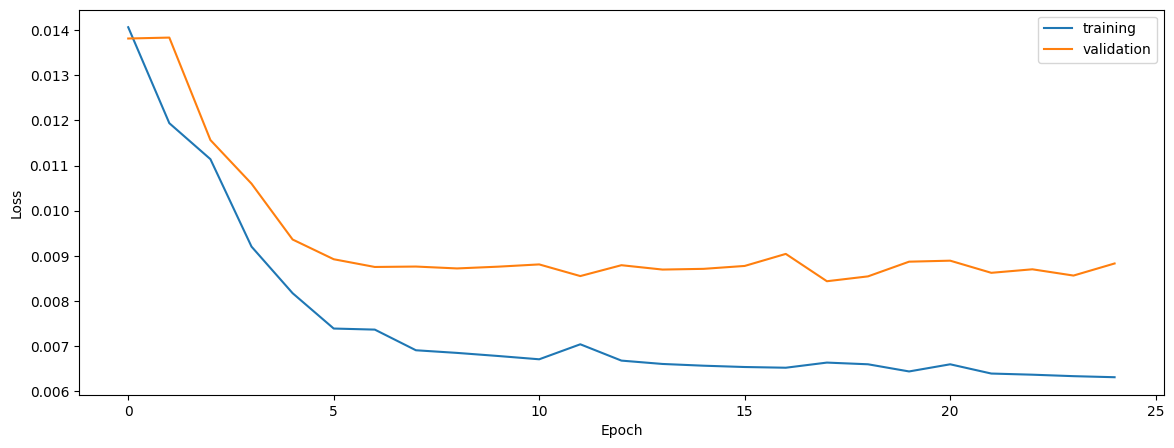

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6824671474272151
0.633101950752287
0.6021558694551435


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6767877335460802
0.6881398758280912
0.656087366527585


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6789056986572305
0.6888970671831963
0.6666647918974709


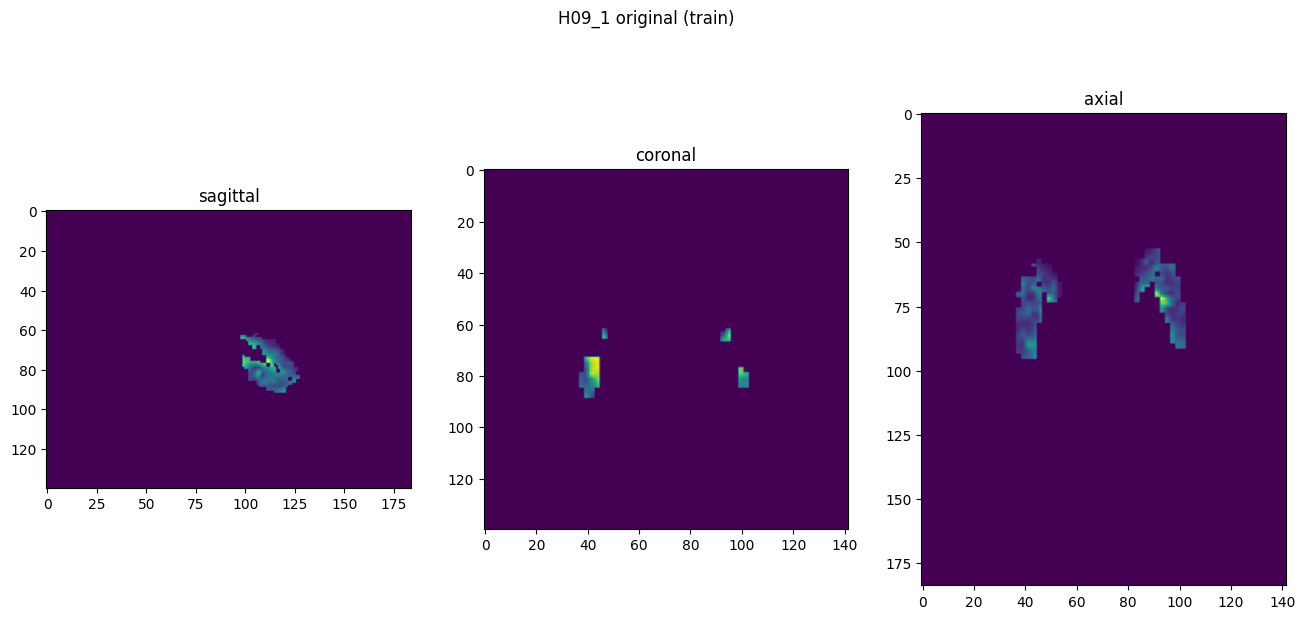

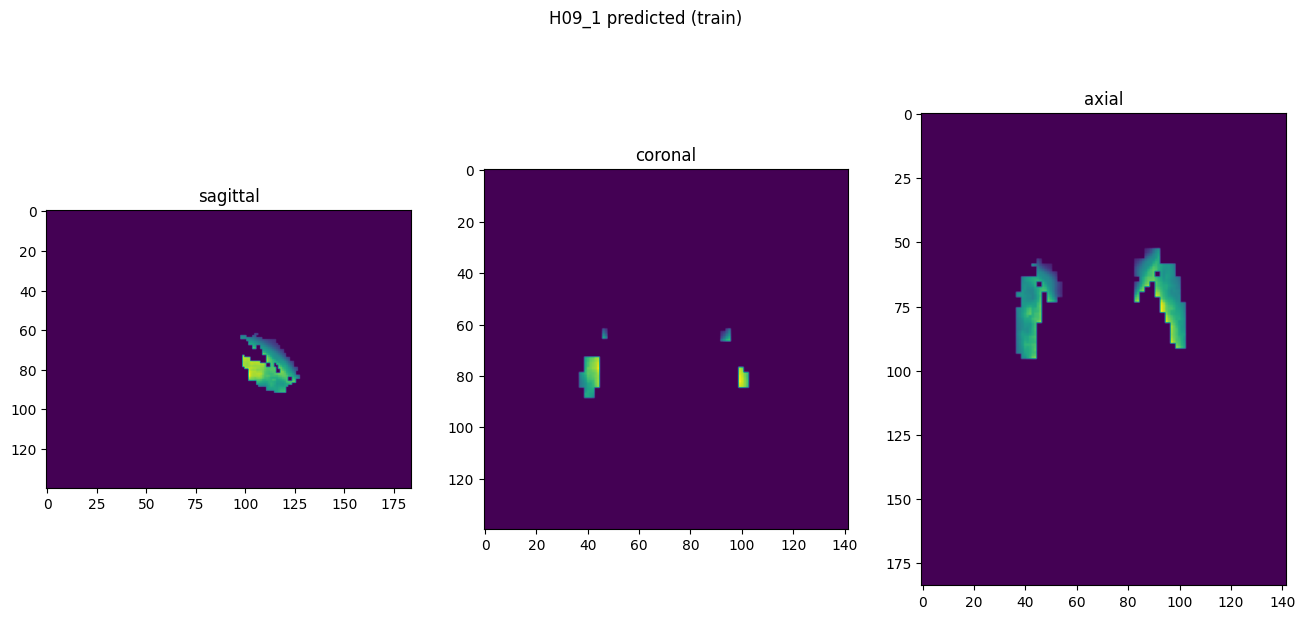

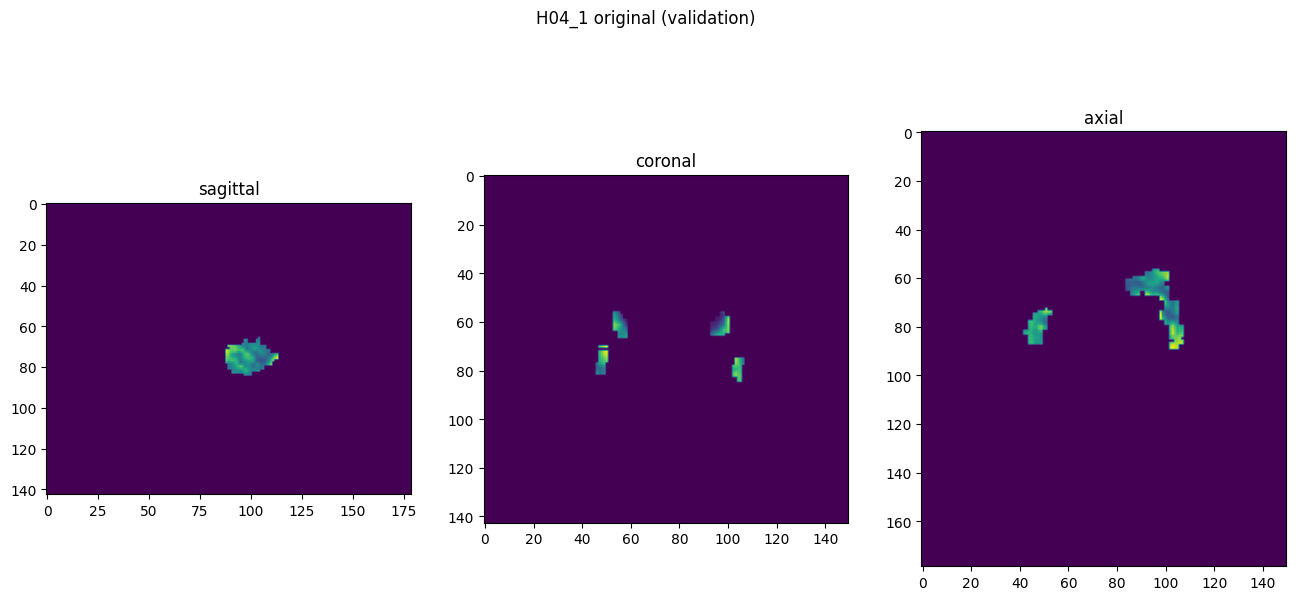

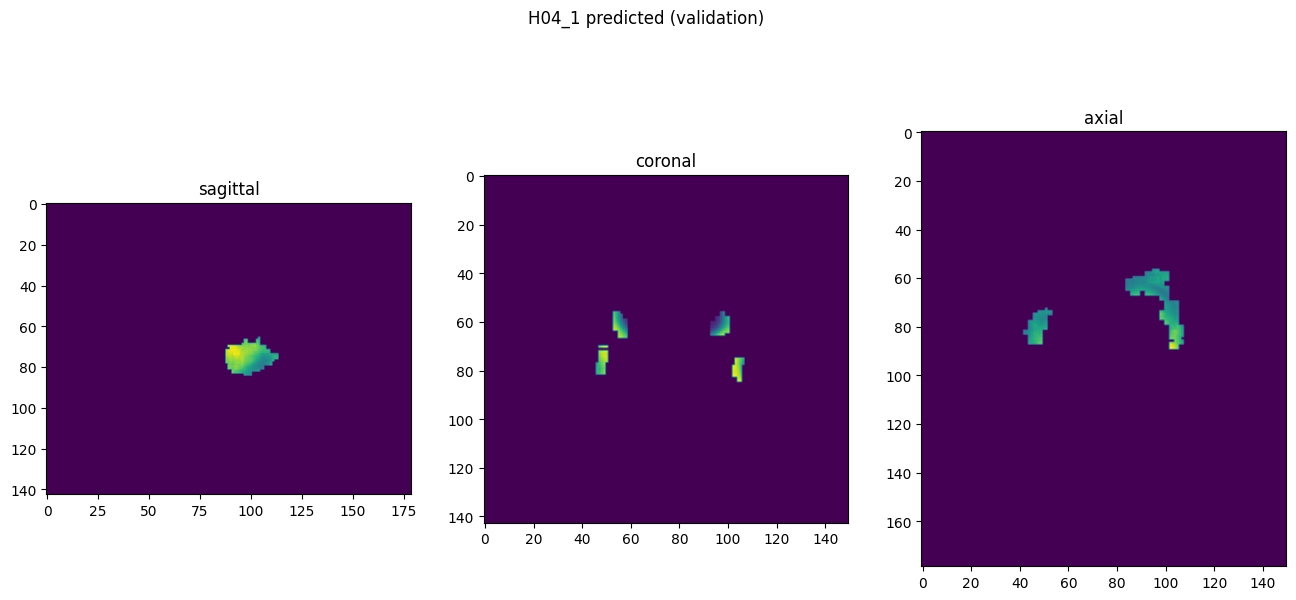

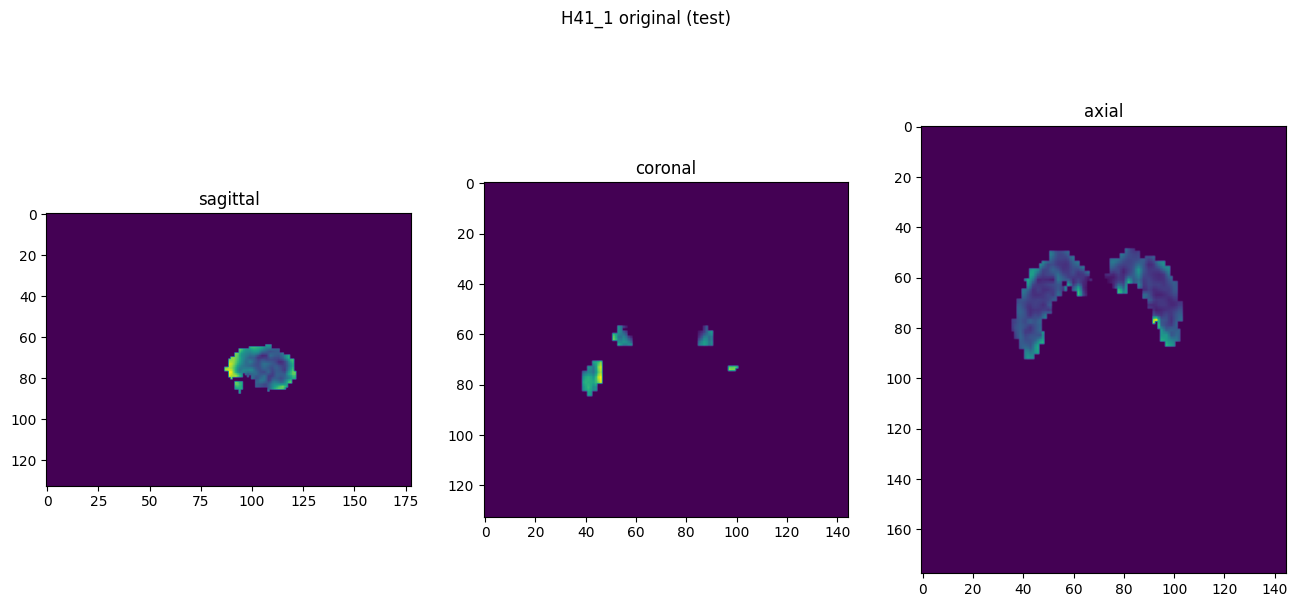

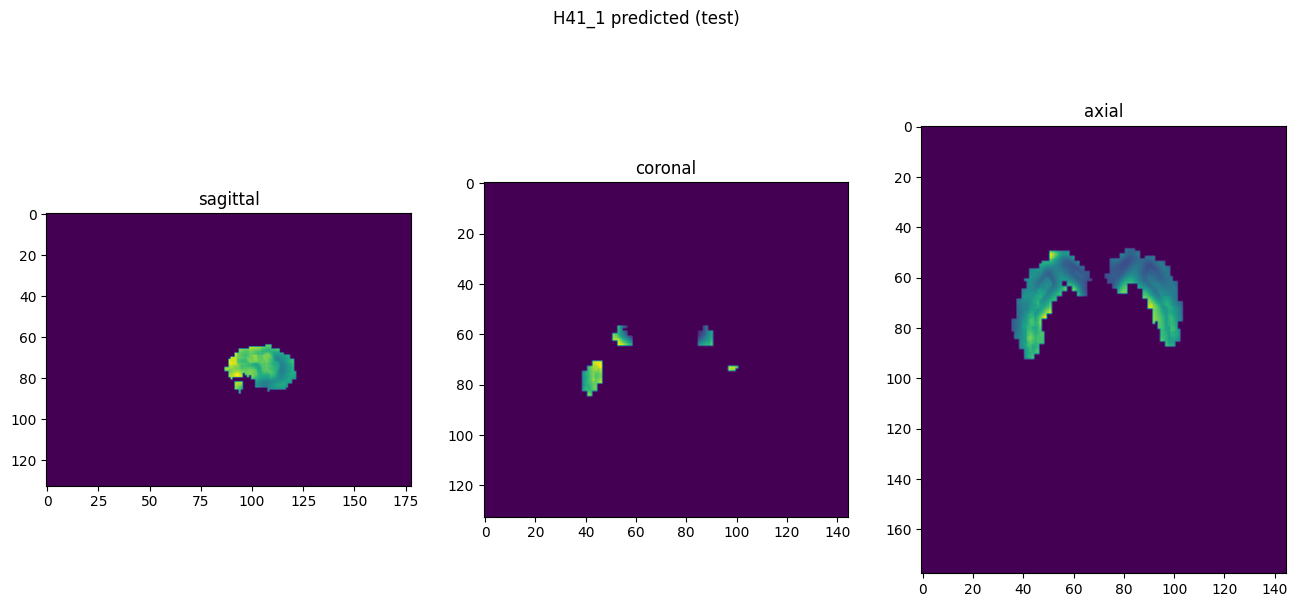

In [10]:
showResults(model, gen, threshold=None, background=False)